<a href="https://colab.research.google.com/github/limengzhaolihai/pytorch-learning/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torchvision import transforms, datasets
import os,PIL,pathlib,warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip crop_images.zip

Archive:  crop_images.zip
replace Ariel_Sharon/Ariel_Sharon_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
cd /content/drive/MyDrive/images/aface

/content/drive/MyDrive/images/aface


In [ ]:
import os,PIL,random,pathlib

data_dir = r"/content/drive/MyDrive/images/aface/"
data_dir = pathlib.Path(data_dir)

data_paths  = list(data_dir.glob('*'))
classeNames = sorted(item.name for item in data_dir.glob('*/') if item.is_dir() and item.name != '.ipynb_checkpoints')
classeNames





['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Hugo_Chavez',
 'Tony_Blair']

In [ ]:
# train_transforms = transforms.Compose([
#     transforms.Resize([224, 224]),  # 将输入图片resize成统一尺寸
#     # transforms.RandomHorizontalFlip(), # 随机水平翻转
#     transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
#     transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的。
# ])

# total_data = datasets.ImageFolder("/content/drive/MyDrive/images/aface/",transform=train_transforms)
# total_data
import os
from torchvision import datasets
train_transforms = transforms.Compose([
    transforms.Resize([224, 224]),  # 将输入图片resize成统一尺寸
    # transforms.RandomHorizontalFlip(), # 随机水平翻转
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的。
])
# 定义转换
# train_transforms = ...

# 获取目录中的有效类别名称
class_names = [d.name for d in os.scandir("/content/drive/MyDrive/images/aface/") if d.is_dir() and d.name != ".ipynb_checkpoints"]

# 创建 ImageFolder 数据集，并过滤不需要的文件类型
total_data = datasets.ImageFolder(
    "/content/drive/MyDrive/images/aface/",
    transform=train_transforms,
    is_valid_file=lambda fname: fname.endswith(('.jpg', '.jpeg', '.png'))
)
total_data

Dataset ImageFolder
    Number of datapoints: 350
    Root location: /content/drive/MyDrive/images/aface/
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
total_data.class_to_idx


{'Ariel_Sharon': 0,
 'Colin_Powell': 1,
 'Donald_Rumsfeld': 2,
 'George_W_Bush': 3,
 'Gerhard_Schroeder': 4,
 'Hugo_Chavez': 5,
 'Tony_Blair': 6}

In [ ]:
pwd

'/content/drive/MyDrive'

In [ ]:
!ls

anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


划分数据集

In [ ]:
train_size = int(0.8 * len(total_data))
test_size  = len(total_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(total_data, [train_size, test_size])
train_dataset, test_dataset
batch_size = 64

train_dl = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=1)
test_dl = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=1)
for X, y in test_dl:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break


Shape of X [N, C, H, W]:  torch.Size([64, 3, 224, 224])
Shape of y:  torch.Size([64]) torch.int64


In [ ]:
from torchvision.models import vgg16

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# 加载预训练模型，并且对模型进行微调
model = vgg16(pretrained = True).to(device) # 加载预训练的vgg16模型

for param in model.parameters():
    param.requires_grad = False # 冻结模型的参数，这样子在训练的时候只训练最后一层的参数

# 修改classifier模块的第6层（即：(6): Linear(in_features=4096, out_features=2, bias=True)）
# 注意查看我们下方打印出来的模型
model.classifier._modules['6'] = nn.Linear(4096,len(classeNames)) # 修改vgg16模型中最后一层全连接层，输出目标类别个数
model.to(device)
model


Using cuda device


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 56.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

训练模型

In [ ]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小
    num_batches = len(dataloader)   # 批次数目, (size/batch_size，向上取整)

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率

    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)

        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失

        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新

        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()

    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss
    # ```
    ## 2. 编写测试函数

# 测试函数和训练函数大致相同，但是由于不进行梯度下降对网络权重进行更新，所以不需要传入优化器
# ```python
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小
    num_batches = len(dataloader)          # 批次数目, (size/batch_size，向上取整)
    test_loss, test_acc = 0, 0

    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)

            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)

            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss


In [ ]:
def adjust_learning_rate(optimizer, epoch, start_lr):
    # 每 2 个epoch衰减到原来的 0.98
    lr = start_lr * (0.92 ** (epoch // 2))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

learn_rate = 1e-4 # 初始学习率
# optimizer  = torch.optim.SGD(model.parameters(), lr=learn_rate)
# 调整优化器
# SGD即梯度下降易得到局部最优，而Adam可得到全局最优
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)


In [ ]:
import copy

loss_fn    = nn.CrossEntropyLoss() # 创建损失函数
epochs     = 200

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

best_acc = 0    # 设置一个最佳准确率，作为最佳模型的判别指标

for epoch in range(epochs):
    # 更新学习率（使用自定义学习率时使用）
    adjust_learning_rate(optimizer, epoch, learn_rate)

    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, optimizer)
    # scheduler.step() # 更新学习率（调用官方动态学习率接口时使用）

    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)

    # 保存最佳模型到 best_model
    if epoch_test_acc > best_acc:
        best_acc   = epoch_test_acc
        best_model = copy.deepcopy(model)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)

    # 获取当前的学习率
    lr = optimizer.state_dict()['param_groups'][0]['lr']

    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%, Test_loss:{:.3f}, Lr:{:.2E}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss,
                            epoch_test_acc*100, epoch_test_loss, lr))

# 保存最佳模型到文件中
PATH = '/content/drive/MyDrive/images/starFace_best_model_2.pth'  # 保存的参数文件名
torch.save(model.state_dict(), PATH)

print('Done')



Epoch: 1, Train_acc:13.2%, Train_loss:1.982, Test_acc:20.0%, Test_loss:1.957, Lr:1.00E-04
Epoch: 2, Train_acc:22.1%, Train_loss:1.933, Test_acc:20.0%, Test_loss:1.898, Lr:1.00E-04
Epoch: 3, Train_acc:21.4%, Train_loss:1.917, Test_acc:27.1%, Test_loss:1.881, Lr:9.20E-05
Epoch: 4, Train_acc:21.8%, Train_loss:1.894, Test_acc:30.0%, Test_loss:1.834, Lr:9.20E-05
Epoch: 5, Train_acc:24.6%, Train_loss:1.866, Test_acc:30.0%, Test_loss:1.839, Lr:8.46E-05
Epoch: 6, Train_acc:25.4%, Train_loss:1.850, Test_acc:31.4%, Test_loss:1.803, Lr:8.46E-05
Epoch: 7, Train_acc:24.6%, Train_loss:1.844, Test_acc:37.1%, Test_loss:1.888, Lr:7.79E-05
Epoch: 8, Train_acc:28.6%, Train_loss:1.778, Test_acc:37.1%, Test_loss:1.836, Lr:7.79E-05
Epoch: 9, Train_acc:32.5%, Train_loss:1.799, Test_acc:40.0%, Test_loss:1.817, Lr:7.16E-05
Epoch:10, Train_acc:30.7%, Train_loss:1.768, Test_acc:42.9%, Test_loss:1.835, Lr:7.16E-05
Epoch:11, Train_acc:32.9%, Train_loss:1.780, Test_acc:45.7%, Test_loss:1.783, Lr:6.59E-05
Epoch:12, 

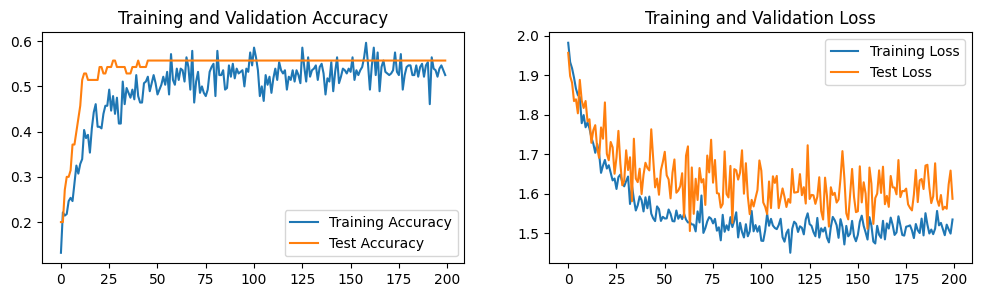

In [ ]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
from PIL import Image

classes = list(total_data.class_to_idx)

def predict_one_image(image_path, model, transform, classes):

    test_img = Image.open(image_path).convert('RGB')
    plt.imshow(test_img)  # 展示预测的图片

    test_img = transform(test_img)
    img = test_img.to(device).unsqueeze(0)

    model.eval()
    output = model(img)

    _,pred = torch.max(output,1)
    pred_class = classes[pred]
    print(f'预测结果是：{pred_class}')


预测结果是：Ariel_Sharon


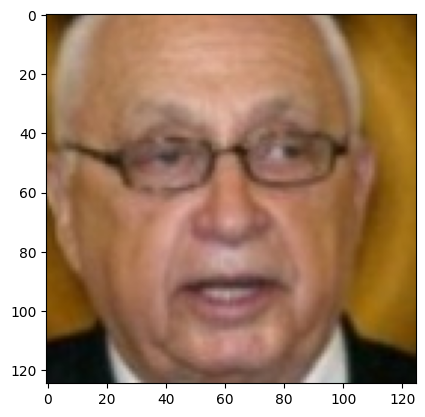

In [ ]:
# 预测训练集中的某张照片
predict_one_image(image_path='/content/drive/MyDrive/images/aface/Ariel_Sharon/Ariel_Sharon_0052.jpg',
                    model=model,
                    transform=train_transforms,
                    classes=classes)


评估

通过transforms对数据进行增强,使准确度提高了

In [ ]:
best_model.eval()
epoch_test_acc, epoch_test_loss = test(test_dl, best_model, loss_fn)
epoch_test_acc, epoch_test_loss


(0.5571428571428572, 1.7418696284294128)

In [ ]:
# 查看是否与我们记录的最高准确率一致
epoch_test_acc


0.5571428571428572